In [1]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.fftpack import fft, fftfreq, ifft
from tqdm.notebook import tqdm
if sys.path[-1] != "..": sys.path.append("..")
import model
from common import cosmology, rh_neutrino, constants, constraints
model = importlib.reload(model)
cosmology = importlib.reload(cosmology)
from common import util

## One interessting (and ~ working) field evolution

CPU times: user 4.17 s, sys: 18.1 ms, total: 4.18 s
Wall time: 4.25 s


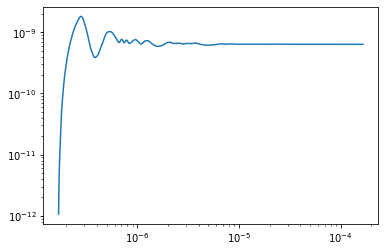

In [2]:
f_a = 1e10
chi0 = 1e9
m_chi = 1e-2 # this should be irrelevant
m_a = constraints.minimal_axion_mass_from_decay(f_a) 
H_inf = max(constraints.calc_H_inf_max(f_a), constraints.calc_H_inf_max(chi0))
assert m_chi < H_inf
assert m_a < H_inf
Gamma_phi = H_inf
g = 1e-3
%time sol = model.simulate(m_a, f_a, Gamma_phi, H_inf, chi0, m_chi, g, rtol=1e-5) # , solver="RK45")
plt.loglog(sol.t, cosmology.n_L_to_eta_B_final(sol.T, sol.n_L))
#model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, chi0, m_chi, g)

Text(0.5, 0, 't * GeV')

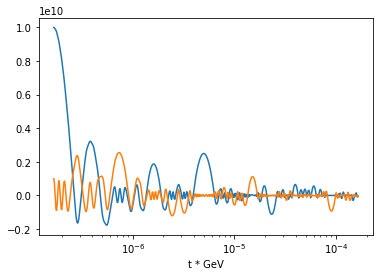

In [166]:
plt.semilogx(sol.t, sol.theta * f_a, label="axion")
plt.semilogx(sol.t, sol.chi, label="chion")
plt.xlabel("t * GeV")

In [167]:
Gamma_a = model.calc_Gamma_a_SU2(m_a, f_a)
1 / Gamma_a

3.386795516762904e+21

## Simulate the field evolutions further into the future (only the field, assume rad dom)

In [3]:
def rhs(t, y, m_a, m_chi, g, Gamma_a):
    H = 1 / (2*t)
    a, a_dot, chi, chi_dot = y
    return (
        a_dot,
        - 3 * H * a_dot - m_a**2 * a - g * a * chi**2,
        chi_dot,
        - 3 * H * chi_dot - m_chi**2 * chi - g * chi * a**2,
    )
span = 1000
steps = np.geomspace(sol.t[-1], sol.t[-1] * span, 1000)
initial = (f_a * sol.theta[-1], sol.theta_dot[-1] * f_a, sol.chi[-1], sol.chi_dot[-1])
Gamma_a = model.calc_Gamma_a_SU2(m_a, f_a)
more_sol = solve_ivp(rhs, (steps[0], steps[-1]), initial, args=(m_a, m_chi, g, Gamma_a), t_eval=steps, rtol=1e-5)

Text(0.5, 0, 't * GeV')

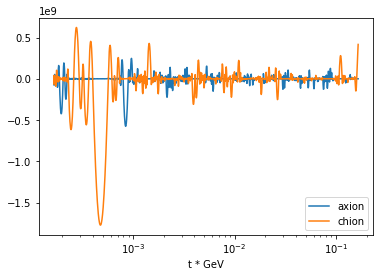

In [178]:
plt.plot(more_sol.t, more_sol.y[0], label="axion")
plt.plot(more_sol.t, more_sol.y[2], label="chion")
plt.legend()
plt.xscale("log")
plt.xlabel("t * GeV")

## Look at the energy density

In [4]:
moving_average = lambda w, xs: np.convolve(xs, np.ones(w), 'valid') / w

In [5]:
# the / 2 in the coupling is bc then a_energy + chi_energy = energy_tot
chi_energy = 0.5 * more_sol.y[3]**2 + 0.5 * m_chi**2 * more_sol.y[2]**2 + g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2
a_energy = 0.5 * more_sol.y[1]**2 + 0.5 * m_a**2 * more_sol.y[0]**2 + g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2

In [12]:
total_energy = chi_energy + a_energy

In [187]:
p, log_A = np.polyfit(np.log(moving_average(w, more_sol.t)), np.log(moving_average(w, chi_energy)), 1)
# rho = A * t^p 
# log rho = log A + p * log t
print("p =", p, "w =", -2/3*p - 1)

p = -2.034012864231919 w = 0.35600857615461257


No handles with labels found to put in legend.


Text(0.5, 0, 't * GeV')

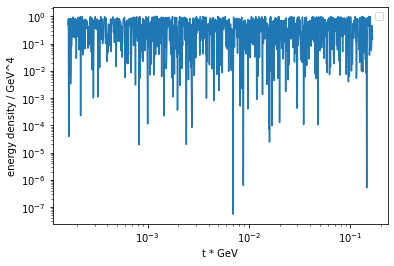

In [11]:
#plt.loglog(more_sol.t, chi_energy, label="chion")
w = 200
#plt.loglog(moving_average(w, more_sol.t),  moving_average(w, chi_energy), label="mov. avg. chion")
#plt.loglog(more_sol.t, a_energy, label="axion")
#plt.loglog(more_sol.t, np.exp(log_A) * more_sol.t**p, label="chion fit")
plt.loglog(more_sol.t, (total_energy / (g * more_sol.y[0]**2 * more_sol.y[2]**2))**(-1))
#plt.loglog(more_sol.t, g * more_sol.y[0]**2 * more_sol.y[2]**2)
plt.legend()
plt.ylabel("energy density / GeV^4")
plt.xlabel("t * GeV")

## Equation of State

In [13]:
chi_pressure = 0.5 * more_sol.y[3]**2 - 0.5 * m_chi**2 * more_sol.y[2]**2 - g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2
a_pressure = 0.5 * more_sol.y[1]**2 - 0.5 * m_a**2 * more_sol.y[0]**2 - g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2

In [14]:
total_pressure = chi_pressure + a_pressure

In [15]:
chi_eos = chi_pressure / chi_energy
a_eos = a_pressure / a_energy

In [16]:
w = 100
total_eos = moving_average(w, total_pressure) / moving_average(w, total_energy)

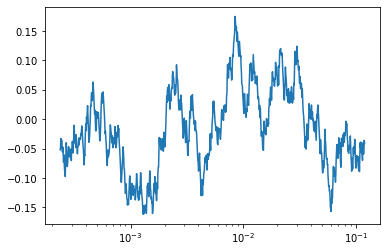

In [17]:
plt.semilogx(moving_average(w, more_sol.t), total_eos)

## Virial Theorem

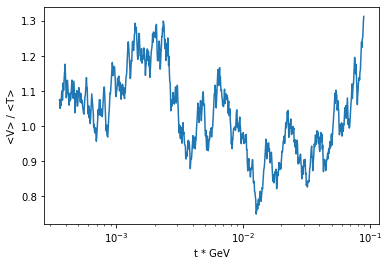

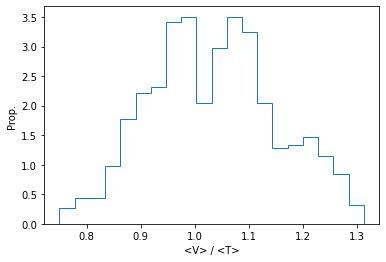

In [264]:
w = 200
T_avg = moving_average(w, 0.5 * more_sol.y[1]**2 + 0.5 * more_sol.y[3]**2)
V_avg = moving_average(w, 0.5 * m_chi**2 * more_sol.y[2]**2 + g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2 + 
                          0.5 * m_a**2 * more_sol.y[0]**2 + g * more_sol.y[0]**2 * more_sol.y[2]**2 / 2)
t_avg = moving_average(w, more_sol.t)
plt.semilogx(t_avg, V_avg / T_avg)
plt.xlabel("t * GeV")
plt.ylabel("<V> / <T>")
plt.show()
plt.hist(V_avg / T_avg, histtype="step", density=True, bins=20);
plt.xlabel("<V> / <T>")
plt.ylabel("Prop.");

## Fluctuations

Text(0, 0.5, 'fluctuations')

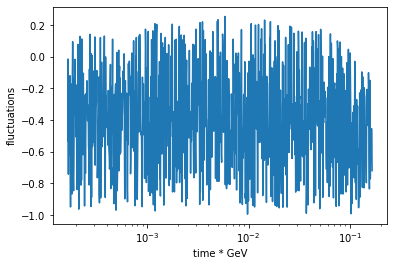

In [174]:
mean = np.exp(log_A) * more_sol.t**p
fluctuations = (chi_energy - mean) / mean
plt.semilogx(more_sol.t, fluctuations)
plt.xlabel("time * GeV")
plt.ylabel("fluctuations")

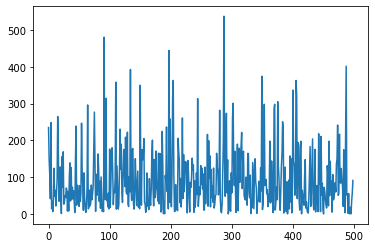

In [175]:
f = fft(fluctuations)
plt.plot(np.abs(f[1:len(f)//2])**2)

Text(0, 0.5, 'probability')

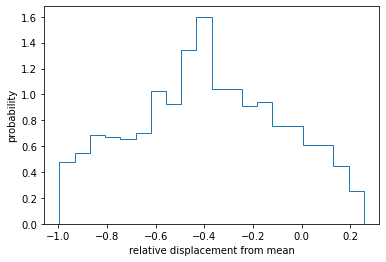

In [257]:
plt.hist(fluctuations, histtype="step", bins=20, density=True);
plt.xlabel("relative displacement from mean")
plt.ylabel("probability")

array([-1.50877308,  3.92971012])

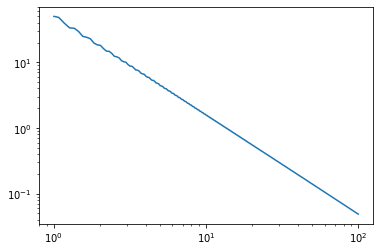

In [100]:
def rhs2(t, y, m):
    H = 1 / (2*t)
    a, adot = y
    return (
        adot,
        - 3 * H * adot - m**2 * a
    )
m = 10
s = solve_ivp(rhs2, (1, 100), (1.0, 0), args=(m,))
e = 0.5 * m**2 * s.y[0]**2 + 0.5 * s.y[1]**2
plt.loglog(s.t, e)
np.polyfit(np.log(s.t), np.log(e), 1)

## This means the decay simulation is wrong

In [192]:
sol_axion_mat = model.simulate_axion_decay(m_a, f_a, g, sol, p=3)
sol_axion_rad = model.simulate_axion_decay(m_a, f_a, g, sol, p=4)

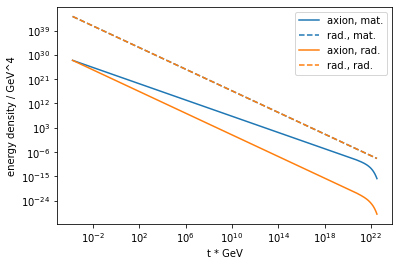

In [193]:
plt.plot(sol_axion_mat.t, sol_axion_mat.rho_a, color="tab:blue", ls="-", label="axion, mat.")
plt.plot(sol_axion_mat.t, sol_axion_mat.rho_R, color="tab:blue", ls="--", label="rad., mat.")
plt.plot(sol_axion_rad.t, sol_axioWe can use them to expand any other solution. For real solutions, such a Fourierexpansion willn_rad.rho_a, color="tab:orange", ls="-", label="axion, rad.")
plt.plot(sol_axion_rad.t, sol_axion_rad.rho_R, color="tab:orange", ls="--", label="rad., rad.")
plt.xlabel("t * GeV")
plt.ylabel("energy density / GeV^4")
plt.legend()
plt.xscale("log")
plt.yscale("log")

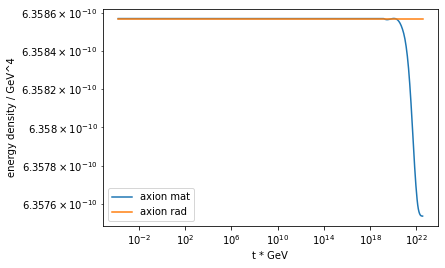

In [194]:
plt.loglog(sol_axion_mat.t, cosmology.n_L_to_eta_B_final(sol_axion_mat.T, sol_axion_mat.n_L), label="axion mat")
plt.loglog(sol_axion_rad.t, cosmology.n_L_to_eta_B_final(sol_axion_rad.T, sol_axion_rad.n_L), label="axion rad")
plt.xlabel("t * GeV")
plt.ylabel("energy density / GeV^4")
plt.legend()